# RESCUE
**Renewable Energy Salient Combined Uncertainty Estimator**

## *Description:*
A machine-learning based framework to quantify the short-term uncertainty in netload forecast developed by E3. 
The main strucutre of the model include a two layer artificial neural net with the pinball loss function as objective. Conditional on combinations of input, the model should be able to output quantile forecast for the net-load forecast error.

This notebook contains the work load of ingesting pre-processed data, set up cross validation folds, training and deployment, and calling functions for diagnostics. For detailed implementation of data preprocessing or quoted functions, please refer to other script files. This project is available in the [e3/RESCUE](https://github.com/e3-/RESCUE) Github online repository. 

In the preliminary use case, the quantile forecast is trained on the response variable. For CAISO, as we are using RTPD forecast - RTD forecast as the response variable, the quantiles is actually on forecast difference rather than forecast error. Nevertheless, the model structure and the logic still holds the same.

## *Highlights:*
1. Incorporating a wide gamut of information: weather, calendar, forecast, and lagged error aware. 
2. Inherrent handles resource correlation as solar,wind, and load errors are co-trained within the model.
3. Produces multiple prediction intervals for expected error in netload forecasting, for cherry picking down-stream
4. Model agnostic. No requirement on knowledge of the inner workings of the netload forecast
5. Adheres to best practice in statistics: cross validation, normalization, early-stopping, etc.

## *To-dos:*
1. Standardize the output for stability;

## *Authors:* 
Yuchi Sun, Vignesh Venugopal, Charles Gulian

In [1]:
# Import third party packages
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt 

# Import self defined packages
import cross_val
import utility
import diagnostics

# 0. User Inputs

In [2]:
#==== User Defined inputs ====
model_name = 'rescue_v1_1' # name of the model. Recommend to include version number

# Target quantiles of the prediction 
PI_percentiles = np.array([0.025, 0.05, 0.25, 0.5,0.75, 0.95, 0.975]) # quantiles to predict

# Structural parameter of the ANN network
num_neurons = 10
activation_type = 'relu'

# Cross validation parameters
num_cv_folds = 10 # number of cross validation folds

# Training parameters
batch_size = 64 # size of each mini-batch in the SGD
max_epochs = 50 # Maximum number of epochs in training. In each epoch, each training data is used exactly once
optimizer_choice = 'adam' # Optimizer choice. Default to ADAM, a popular choice that have 1st and 2nd order momentum

# Early stopping parameters
early_stop_monitor = 'val_loss' # The metrics to watch when deciding whether to stop. Recommendation: Validation loss as in 'val_loss'
early_stop_min_delta = 0.5 # if the difference/decrease in loss is less than min_delta, the model is considered no longer improving
early_stop_patience = 3 # For number of patience epochs, observe if the model has improved more than min_delta
early_stop_verbosity = 1 # 0: no output, 1: some output, 2: full output

# Check points parameters
ckpt_monitor = 'val_loss' # Check points are only saved when there is an improvement in ckpt monitor

# Losses and Metrics log parameters
log_activation_freq = 0 # the frequency of logging hidden layer activation's histogram. Default to not log
log_update_freq = 'epoch' # The frequency of logging. Default to record at the end of every epoch

# Visualization parameters
default_dpi = 300

# define the mapping between internal feature name and feature label used in plotting
label_to_feature_map = {"Solar_RTPD_Forecast_T+1":"Solar Generation (MW)",
                       "Wind_RTPD_Forecast_T+1":"Wind Generation (MW)",
                       "Load_RTPD_Forecast_T+1":"Load (MW)",
                       "Days_from_Start_Date_T+1":"Date of Observation",
                       "Hour_Angle_T+1":"Hour",
                       "Day_Angle_T+1":"Month"}
# Training and validation loss comparison for multiple folds
x_jitter = 0.1
metrics_to_idx_map = {'Loss (MW)':0, 'Coverage Probability (%)':1}
metrics_to_compare = ['Loss (MW)', 'Coverage Probability (%)'] # choose in metrics_to_idx_map's keys


# Time series
ts_ranges = ['20170201','20170501','20170801','20171101'] # the example range of time series to plot



# 1. Data Ingestion

Load in pre-processed trainval dataset that includes all input features/ output response for both training and validation. Prepare the cross validation splitting masks. Set up directory structure to store intermediate (`log`, `checkpoints`) and final outputs (`models`, `outputs`,`diagnostics`).


In [3]:
# Load in/ Create folder structure for the current model
dir_str = utility.Dir_Structure(model_name = model_name)

# Read in input and output of the training and validation samples from data pipeline. 
# This should be an output of the data_preprocessing script
input_trainval = pd.read_pickle(dir_str.input_trainval_path)
output_trainval = pd.read_pickle(dir_str.output_trainval_path)
assert input_trainval.shape[0] == output_trainval.shape[0], "Input and output shape mismatch!"
n_samples = input_trainval.shape[0]

# Use cross validation script to conduct intra-day consecutive trainval splitting. The number of folds is 
# determined by num_cv_folds. The data of the same day would not end up separately in training and validation
# to not overestimate model performance.
val_masks_all_folds = cross_val.get_CV_masks(input_trainval.index, num_cv_folds, dir_str.shuffled_indices_path)

# confirm the PI percentiles are symmetrical and 0.5 is one of the target quantile
for PI in PI_percentiles:
    assert np.allclose(1-PI_percentiles, PI_percentiles[::-1]), "Not all PI intervals are constructed symmetrically!"
assert 0.5 in PI_percentiles, "Median forecast (P50) must be produced!"

Day block shuffling pre-determnined....
Done....
Creating train val masks for each fold....
Train and val masks are ready!


# 2. Model Definition
Define the various component of the model that are active at various stage of the model life cycle. Before training: model structure, loss function. During training: call backs and metrics. After training: Saving functions. 

## 2.1 Model Structure.
The RESCUE model is built with the Keras [functional API](https://www.tensorflow.org/guide/keras#model_subclassing). As it stands right now, it is a two layer ANN network with a pre-processing normalization layer. Rectified linear units is used as the activation function for the hidden layers, while the last layer is a direct linear regression.                        

In [4]:
# Create a model that include the normalization layer
inputs = tf.keras.Input(shape=input_trainval.shape[1:])

# Create a Normalization layer and set its internal state using the training data
normalizer = tf.keras.layers.experimental.preprocessing.Normalization(name = 'Normalization')
norm_inputs = normalizer(inputs)

# A two-layer ANN network for regression
dense1 = tf.keras.layers.Dense(num_neurons, activation=activation_type)
hidden1 = dense1(norm_inputs)
dense2 = tf.keras.layers.Dense(num_neurons, activation=activation_type)
hidden2 = dense2(hidden1)
dense3 = tf.keras.layers.Dense(1)
outputs = dense3(hidden2)

# define model from inputs to outputs
rescue_model = tf.keras.Model(inputs, outputs)

## 2.2 Loss Function

The pinball loss function is used here to provide a quantile forecast rather than a median forecast. With increasing sample size, the pinball loss would converge to the quantile forecast of a variable conditional on the input variable. The quantile is given by a parameter `tau`, which is set in the user input as PI percentiles. 

One property of the pinball loss is that for 0% and 100% percentile, the pinball loss is always 0 no matter the model and parameter choice, while the median forecast have the highest loss. So comparing the losses across different quantiles makes little sense, and is advised against. For more information on pinball losses, check out [this wiki](https://en.wikipedia.org/wiki/Quantile_regression).


In [5]:
class PinballLoss(tf.keras.losses.Loss):
    def __init__(self, tau=0.5, name="pinball_loss"):
        super().__init__(name=name)
        self.tau = tau # the target quantile

    def call(self, y_true, y_pred):
        err = y_true - y_pred # the convention is always true - pred
        # essentially, quantile regression takes two region. For values bigger than the quantile forecast,
        # they are weighted by 1-tau, while for values smaller than the forecast it's weighted by tau.
        skewed_mse = tf.math.reduce_mean(tf.math.maximum(self.tau * err, (self.tau - 1) * err), axis=0)

        return skewed_mse

## 2.3 Metrics

In tensorflow terminology, metrics are quantities that are calculated as the training goes on to aid your judgement on model's fitness and completeness. In our use cases, we define two metrics for this purpose: coverage probability and average interval width.

For prediction intervals, coverage probability refers to how often are the actual forecast included in the prediciton interval bands. Here we slightly modify the definition and refers to how often are the actual forecast smaller than the target quantile. For a well behaving model, the CP would converge to target quantile tau.

For average interval width, it normally refers to the width of a prediction interval band. Again, we make a slight modification here. Since in practice, the forecast for quantiles above 50% are upwards reserve and normally positive, and below 50% are downwards reserve and normally negative, we are simply using the quantile forecast's absolute distance to 0 as the interval width here. For interpretation, we are looking for smaller requirement for better band width, but also high flexibitliy wrt to varying condidtions.


In [6]:
class CoverageProbability(tf.keras.metrics.Metric):
    def __init__(self, name = 'CP',**kwargs):
        super(CoverageProbability, self).__init__(name = name, **kwargs)
        self.coverage_probability = self.add_weight(name = 'CP', initializer="zeros", dtype = tf.float64)
        # the cumulative number of samples and the number of samples smaller than current quantile forecast
        self.cum_n_samples = self.add_weight(name = 'n_samples', initializer="zeros", dtype = tf.int32)
        self.cum_n_covered = self.add_weight(name = 'n_covered', initializer="zeros", dtype = tf.int32)
        
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        # the state would be updated everytime we have a new calculation
        self.cum_n_samples.assign_add(tf.size(y_pred, out_type=tf.int32))
        self.cum_n_covered.assign_add(tf.math.count_nonzero(tf.math.less_equal(y_true,y_pred), dtype = tf.int32))
        # cp = n_covered/n_samples
        self.coverage_probability.assign(tf.math.divide(self.cum_n_covered, self.cum_n_samples))

    def result(self):
        return self.coverage_probability

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.coverage_probability.assign(0.0)
        


## 2.4 Callbacks

In tensorflow terminology, callbacks are functions that get executed with certain frequency during training. For our purpose, all the callbacks happen once per epoch and we are using three types of callbacks: Early stopping, check points, and tensor boards. Saving the model is not necessarily a callback, but it also get executed once after the training for the model is complete, so is included in this segment.

1. Early stopping stops the training when certain criteria is met. In general the criteria is that when `monitor` did not improve by more than `min_delta` in `patience` epoch, than the training is stopped. This is a way to effective prevent overfitting to the training data, so the monitor is most often validation loss.  
2. Check points are periodical snap shot of parameter weights saved in case the model training is unexpectedly stopped.  We are saving the `checkpoints`,`logs`, and`trained models` in different folders for different taus and folds.
3. Saving is very similar to check points. Difference is that check points are conducted at the end of every epoch, while saving only happens by the end of training session.
4. The tensorboard callback allow us to visualize and observe losses and all metrics in a pre-compiled tensorboard interface. It can even visualize losses and metrics for multiple folds and taus.

In [7]:
# Early stopping stops the training when certain criteria is met.
cb_early_stopping = tf.keras.callbacks.EarlyStopping(monitor=early_stop_monitor, min_delta=early_stop_min_delta, 
                                                     patience=early_stop_patience, verbose=early_stop_verbosity)

# For the save best only parameter: we will overwrite the current checkpoint if and only if the `val_loss` 
# score has improved. Different fold and tau would end up in different ckpts_dir folder
def get_cb_check_points(tau, fold_idx):
    # make sure models for different tau go to different directories
    ckpts_dir = os.path.join(dir_str.ckpts_dir, "tau_{:.1%}".format(tau),"fold_#{}".format(fold_idx))
    if not os.path.exists(ckpts_dir):
        os.makedirs(ckpts_dir)
    cb_check_points = tf.keras.callbacks.ModelCheckpoint(filepath=ckpts_dir, save_best_only=True, monitor= ckpt_monitor, verbose=0)
    return cb_check_points


# Currrently not logging the histogram of activation and embedding layers. Write log per epoch.
def get_cb_tensor_board(tau, fold_idx):
    # make sure models for different tau and fold would get logged in different directory
    logs_dir = os.path.join(dir_str.logs_dir, "tau_{:.1%}".format(tau),"fold_#{}".format(fold_idx))
    if not os.path.exists(logs_dir):
        os.makedirs(logs_dir)
    cb_tensor_board = tf.keras.callbacks.TensorBoard(logs_dir, histogram_freq= log_activation_freq, 
                                                     embeddings_freq=0,  update_freq=log_update_freq)  
    return cb_tensor_board

# Save the model by the end of each training session. Might be replacible by checkpoints.
def save_rescue_model(model, tau, fold_idx):
    # make sure models for different tau and fold would get logged in different directory
    models_dir = os.path.join(dir_str.models_dir, "tau_{:.1%}".format(tau),"fold_#{}".format(fold_idx))
    if not os.path.exists(models_dir):
        os.makedirs(models_dir)
    
    model.save(models_dir)
    return None   

# 3. Model Training

Training is the process where the parameter of a model changes to reduce some loss function. In our specific case, we are conducting training separtely for each target quantile and each fold. We first split data into training and validation based on current fold number, and then initialize a new model to fit to the training data until the pinball loss meet some stopping criteria, i.e. showing no significant decrease.


In [ ]:
rescue_model_set = {} # intialized container for TF models. Indexed by (tau, fold_idx)
history = {} # intialized container for the training history of models. Indexed by (tau, fold_idx)

# loop through different target quantiles and cross validation folds
for tau in PI_percentiles:
    print("Training model for Prediction interval: {:.1%}".format(tau))
    for fold_idx in range(num_cv_folds):
        print("Cross Validation fold #", fold_idx+1)
        
        # Split into training and validation dataset based on the CV validation masks generated in section 1.
        input_train, output_train = input_trainval[~val_masks_all_folds[fold_idx]], output_trainval[~val_masks_all_folds[fold_idx]]
        input_val, output_val = input_trainval[val_masks_all_folds[fold_idx]], output_trainval[val_masks_all_folds[fold_idx]]
        
        # retain value only and cast to 'float32'. Single precision calculate a lot faster than double precision.
        input_train = input_train.values.astype('float32')
        output_train = output_train.values.astype('float32')
        input_val = input_val.values.astype('float32')
        output_val = output_val.values.astype('float32')

        # Using tf.data API to batch and shuffle the dataset. For shuffling, the buffer size should be bigger than the total 
        # sample count. Or else only the first buffle size of samples would be shuffled 
        train_ds = tf.data.Dataset.from_tensor_slices((input_train, output_train)).shuffle(buffer_size= n_samples).batch(batch_size)
        val_ds = tf.data.Dataset.from_tensor_slices((input_val, output_val)).shuffle(buffer_size = n_samples).batch(batch_size)

        # Make a fresh clone of the rescue model for the specific quantile and fold
        rescue_model_set[(tau, fold_idx)] = tf.keras.models.clone_model(rescue_model)
        # For some layers the paramers are not trainable, and is adapted at the begining to data. E.g.:Normalization layer 
        rescue_model_set[(tau, fold_idx)].get_layer('Normalization').adapt(input_trainval.values)
        # Compiling the loss, optimizer, metrics, and model into one compiled instance
        rescue_model_set[(tau, fold_idx)].compile(loss = PinballLoss(tau = tau), optimizer=optimizer_choice,
                                                  metrics= [CoverageProbability()])
        
        # The training process. Passing in callbacks to use in mid training 
        history[(tau, fold_idx)]= rescue_model_set[(tau, fold_idx)].fit(train_ds, validation_data=val_ds, epochs=max_epochs,
                                                                        callbacks=[cb_early_stopping, get_cb_tensor_board(tau, fold_idx)])
        
        # Save the trained rescue model for each target percentile and fold
        save_rescue_model(rescue_model_set[(tau, fold_idx)], tau, fold_idx)


## 4. Model Inferrence
After the model is trained, we use it to produce quantile predictions on the entire trainval set. Note that the training history is also transformed into and np array here for easy storage and visualizaiton.

In [ ]:
# Initialize container for the inference result for different quantiles/CV folds
multi_index_tau_folds = pd.MultiIndex.from_product([PI_percentiles, range(num_cv_folds)], names = ['Quantiles','Fold ID'])
pred_trainval = pd.DataFrame(index = input_trainval.index, columns = multi_index_tau_folds) 

# Initialize container for the training loss and metric history
num_metrics = len(history[(tau, fold_idx)].params['metrics'])
training_history = np.ones((len(PI_percentiles), num_cv_folds, max_epochs, num_metrics))*np.nan

# looping through all target percentiles and CV folds
for i,tau in enumerate(PI_percentiles):
    print ('Inferring on quantile of {:.1%}'.format(tau))
    for fold_idx in range(num_cv_folds):
        # Record training loss and metrics history
        num_epochs = len(history[(tau, fold_idx)].epoch)
        training_history[i,fold_idx,:num_epochs,:] = pd.DataFrame(history[(tau, fold_idx)].history).values
        
        # Deploy model on the trainval data and record inference results
        pred_trainval.loc[:,(tau,fold_idx)] = rescue_model_set[(tau,fold_idx)].predict(input_trainval.values)
        
#Output inferrence result and training history to hard drive        
pred_trainval.to_pickle(dir_str.pred_trainval_path)
np.save(dir_str.training_hist_path, training_history)

# 5. Diagnostics and Visualizations
This section includes an expanding set of diagnostics and visualization tool to assess the performance of RESCUE model, and check whether the model's behavior ahere to our intuition. As a standalone section, you should be able to skip **section 2-4** and directly start run **section 5** after **section 1**. First we load in the quantile prediction made in the inferrence section and the training history from the training section. They should all be on the hard drive already. from the hard drive if they exist

In [9]:
# load in quantile prediction
if os.path.exists(dir_str.pred_trainval_path):
    pred_trainval = pd.read_pickle(dir_str.pred_trainval_path)
    pred_trainval = pred_trainval.xs(0, axis=1, level = 'Fold ID') # fold ID could really be any
else:
    print('No quantile prediction found! Run section 4 first!')
# load in training history
if os.path.exists(dir_str.training_hist_path):
    training_hist = np.load(dir_str.training_hist_path)
else:
    print('No training history found!')

## 5.1 Tensorboard
Tensorboard is a built-in visualization tool to visualize the losses and metrics during multiple training processes. Use `tensorboard --logdir dir_str.logs_dir` to invoke it in the command line (replace `dir_str.logs_dir` with the folder it's referring to). This is also the reason we did not plot training history for each epoch, as it's done in tensorboard already

**What to look for**: Training loss should converge in the last few epochs. Validation loss should not trail behind training loss by too much.


## 5.2 Forecast uncertainty grouped by input features
Visualize the forecast bias and uncertainty's change w.r.t to different input features. Check if the visualization corroborate or contradict our intuition. Many contradictions would constitute a red flag for model's fidelity.

**What to expect:**
1. **Forecast uncertainty v.s. Solar production**: Forecast uncertainty should be the highest for medium solar production, and low during both no solar and full solar periods.
2. **Forecast uncertainty v.s. Wind production**:  Wind should have less effect on forecast uncertainty than solar. Increases with higher wind production
3. **Forecast uncertainty v.s. Load**: Forecast uncertainty should increase with higher load.
4. **Forecast uncertainty v.s. Hours**: Sunset and sunrise hours are associated with high amount of uncertainty. No solar night time hours should have low uncertainty.
5. **Forecast uncertainty v.s. Season**: Highly dependent on local climate type. For mediterranean climate, expect little to no change, with a slight increase in winter. For continental climate, expect higher uncertainty in summer due to precipitation. For desert climate, expect smaller uncertainty year round, while expecting higher uncertainty year round for oceanic and tropical climates. For monsoon dominated climate, expect higher uncertainty in monsoon season (usually summer).
6. **Forecast uncertainty v.s. Date of installation**: Highly dependent on modeled BA. If the BA experience significant renewable growth, expect increasing uncertainty with time.

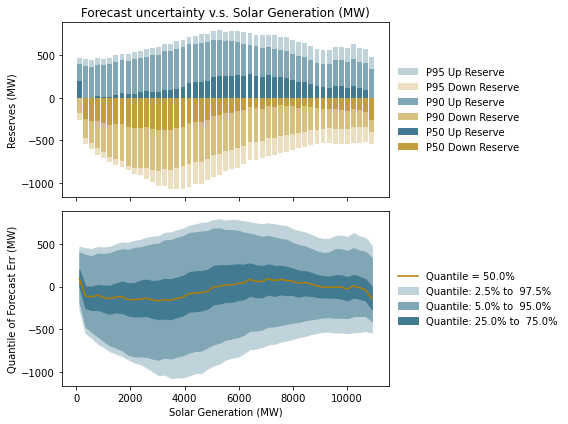

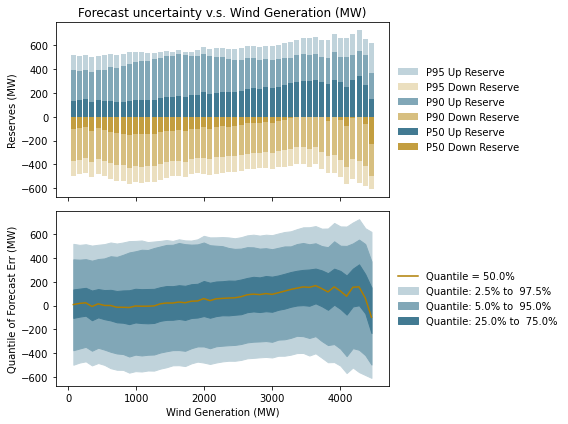

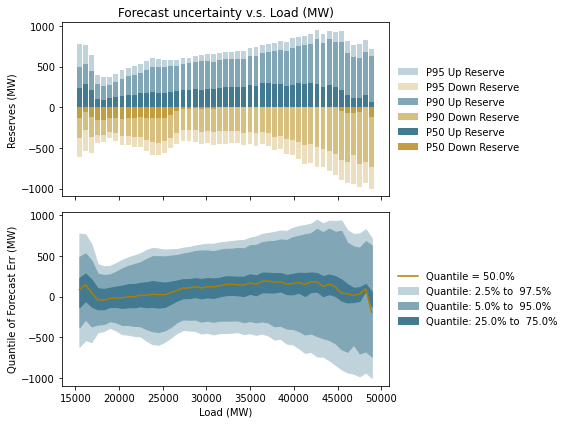

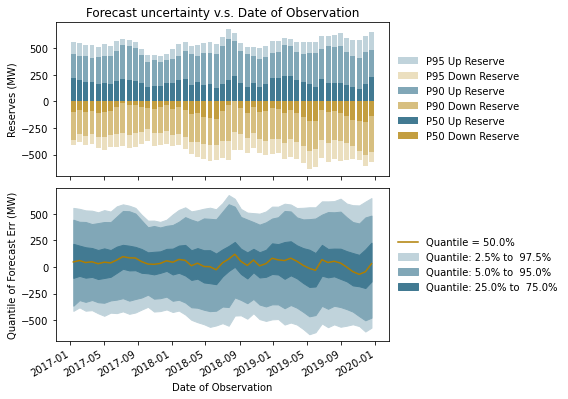

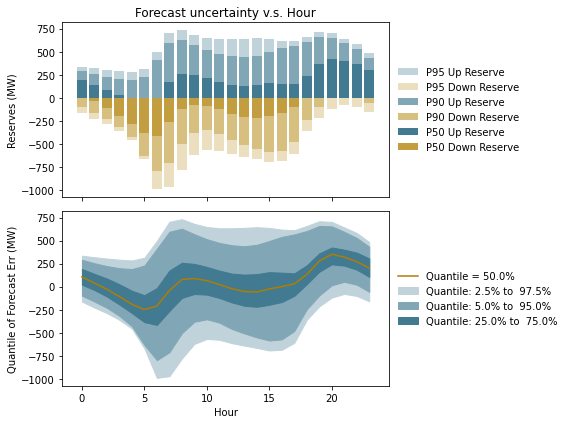

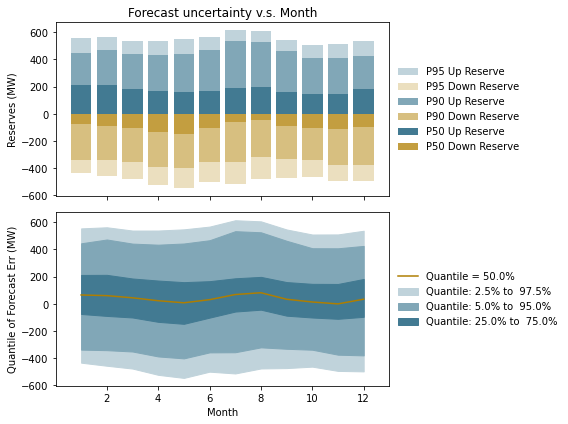

In [10]:
# Demonstrate the change in forecast uncertainty with respect to Solar, wind and load
for feature, label in label_to_feature_map.items():
    # if looking at Hour and Month, binning is derived from index
    if label == "Hour":
        feature_discretized = pred_trainval.index.hour
    elif label == 'Month':
        feature_discretized = pred_trainval.index.month
    else:
        # else the label is derived from dicretizing a continuous input
        feature_discretized = diagnostics.discretize_input(input_trainval[feature])
        if label == 'Date of Observation':
            # for 'Date of Observation', we add the starting date so it shows up as a historical data
            feature_discretized = (pd.Timestamp(input_trainval.index[0].date()) 
                                   + feature_discretized.astype('int')*pd.Timedelta('1D'))
    # plotting the uncertainty and bias for each feature bin
    fig, axarr = diagnostics.plot_uncertainty_groupedby_feature(pred_trainval, feature_discretized, 
                                                                label_to_feature_map[feature])
    
    # special formatting of the x axis when we are using date observation
    if label == 'Date of Observation':
        fig.autofmt_xdate()
    
    fig.savefig(os.path.join(dir_str.diag_dir,label +'.png'), dpi = default_dpi) # save figure

## 5.3 Model performance in different CV folds
Visualizing model performance for all the cross validation folds across training and validation sets. An important tool in assessing the generalizability of the model.

**What to look for:**
1. Distance between training and validation. Smaller distance signifies a small amount of expected performance drop betweeen seen and unseen data, hence better generalizability.
2. Spread among different validation folds: The smaller the spread, the more invariant the model is to its data, and hence better generalizability.

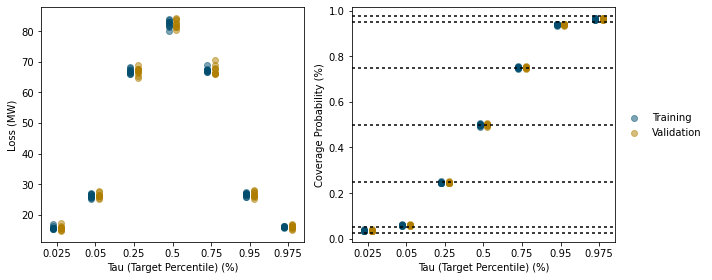

In [11]:
fig, _ =  diagnostics.plot_compare_train_val(training_hist, PI_percentiles,      
                                             metrics_to_idx_map, metrics_to_compare, x_jitter =x_jitter)

fig.savefig(os.path.join(dir_str.diag_dir, 'Train_Val_Comparison.png'), dpi=default_dpi, bbox_inches = 'tight')

## 5.4. Example Time series
Visualize the quantile forecast for a few example days.


**What to look for**:
1. **Smoothness**: Is the reserve interval band changing continuously?
2. **Coverage**: How good is the reserve interval band covering the true forecast error? The more the better.
3. **Exceeding**: What kind of condition seems to lead to exceedance? Hopefully it should be extreme

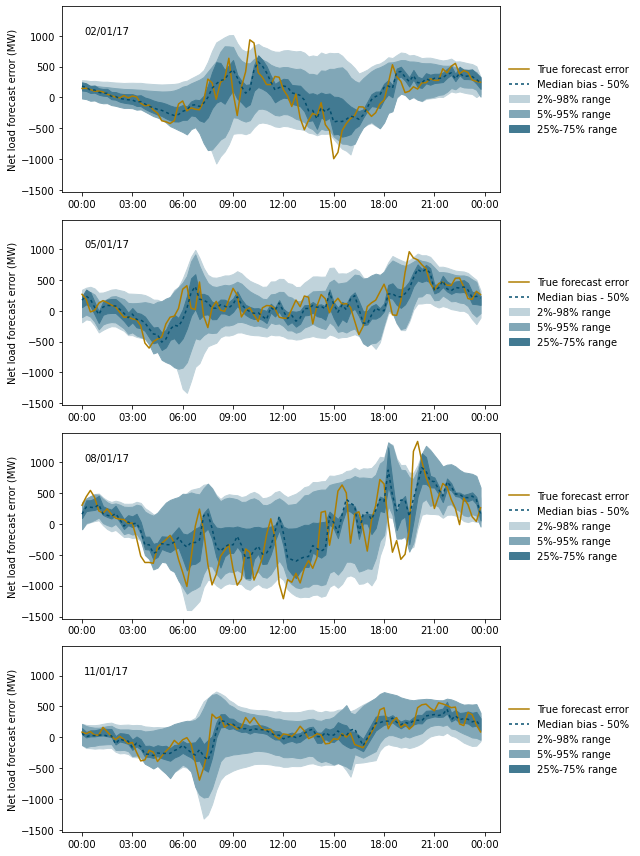

In [12]:
fig, axarr = diagnostics.plot_example_ts(ts_ranges, pred_trainval, output_trainval)
fig.savefig(os.path.join(dir_str.diag_dir,'Example_time_series.png'), dpi = default_dpi, bbox_inches = 'tight')


Archived code: Use `tf.GradientTape` for very fine grained control.

In [9]:
# train_loss = tf.keras.metrics.Mean(name='train_loss')
# test_loss = tf.keras.metrics.Mean(name='test_loss')

# @tf.function
# def train_step(inputs, outputs, model, loss_fn):
#     with tf.GradientTape() as tape:
#         # training=True is only needed if there are layers with different
#         # behavior during training versus inference (e.g. Dropout).
#         predictions = model(inputs, training=True)
#         loss = loss_fn(outputs, predictions)
#     gradients = tape.gradient(loss, rescue.trainable_variables)
#     optimizer.apply_gradients(zip(gradients, rescue.trainable_variables))

#     train_loss(loss)
#     #train_accuracy(outputs, predictions)


# @tf.function
# def test_step(inputs, outputs, model, loss_fn):
#     # training=False is only needed if there are layers with different
#     # behavior during training versus inference (e.g. Dropout).
#     predictions = rescue(inputs, training=False)
#     t_loss = loss_object(outputs, predictions)

#     test_loss(t_loss)
#     #test_accuracy(outputs, predictions)

# EPOCHS = 5

# for epoch in range(EPOCHS):
#   # Reset the metrics at the start of the next epoch
#   train_loss.reset_states()
#   #train_accuracy.reset_states()
#   test_loss.reset_states()
#   #test_accuracy.reset_states()

#   for inputs, outputs in train_ds:
#     train_step(inputs, outputs)

#   for test_inputs, test_outputs in test_ds:
#     test_step(test_inputs, test_outputs)

#   print(
#     f'Epoch {epoch + 1}, '
#     f'Loss: {train_loss.result()}, '
#     #f'Accuracy: {train_accuracy.result() * 100}, '
#     f'Test Loss: {test_loss.result()}, '
#     #f'Test Accuracy: {test_accuracy.result() * 100}'
#   )